# Backtest de Carteira de Dividendos

## Objetivos de Aprendizagem
- Aprender como fazer backtest de uma carteira focada em dividendos
- Analisar o desempenho histórico de estratégias de dividendos
- Identificar limitações na estratégia

## Parâmetros

In [32]:
# Parâmetros para seleção de ações
TOP_N_STOCKS = 10                 # Número de ações para selecionar
MIN_LIQUIDITY = 10000000          # Liquidez mínima (média diária em R$)

# Parâmetros para o backtest
START_DATE = "2023-04-17"         # Data de início do backtest
END_DATE = "2025-04-17"           # Data de fim do backtest (ou usar a data atual)

# Parâmetros para cálculo de métricas
RISK_FREE_RATE = 0.12             # Taxa livre de risco anual (ex: 10%)

## Instalação das Bibliotecas Necessárias

Vamos instalar as bibliotecas necessárias para nossa análise:

In [33]:
%%capture
%pip install yfinance pandas numpy matplotlib requests lxml

## Importando as Bibliotecas

Primeiro, importamos todas as bibliotecas que vamos utilizar neste notebook:

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import matplotlib.dates as mdates
import io

# Setting for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

## Obtendo Dados do Fundamentus

Vamos recuperar os dados de todas as ações do site Fundamentus e transformá-los em um DataFrame para análise:

In [35]:
def get_fundamentus_data():
    """Get stock data from Fundamentus website focusing on specific columns"""
    url = "https://fundamentus.com.br/resultado.php"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    # Make request to the website
    r = requests.get(url, headers=headers)
    
    # Parse HTML table with correct decimal and thousands separators
    html_data = io.StringIO(r.text)
    df = pd.read_html(html_data, decimal=",", thousands=".")[0]
    
    # Convert percentage columns from percentage to decimal
    df['Div.Yield'] = pd.to_numeric(df['Div.Yield'].str.replace('%', '').str.replace(',', '.'), errors='coerce') / 100
       
    # Select only the columns we need
    needed_columns = ["Papel", "Div.Yield", "Liq.2meses"]
    df = df[needed_columns]
    
    return df

# Get the data
fundamentus_df = get_fundamentus_data()

print(f"Total number of stocks: {len(fundamentus_df)}")

# Check specific columns of interest
for col_name in ['Div.Yield', 'Liq.2meses']:
    print(f"{col_name} range: {fundamentus_df[col_name].min()} to {fundamentus_df[col_name].max()}")
    print(f"{col_name} mean: {fundamentus_df[col_name].mean()}")

fundamentus_df.head()

Total number of stocks: 991
Div.Yield range: 0.0 to 1.2337
Div.Yield mean: 0.02474979797979798
Liq.2meses range: 0.0 to 1555690000.0
Liq.2meses mean: 19651843.00410696


,Papel,Div.Yield,Liq.2meses
0,CSTB4,0.0,0.0
1,MNSA3,0.0,0.0
2,CLAN3,0.0,0.0
3,CFLU4,0.0,0.0
4,IVTT3,0.0,0.0


## Selecionando Ações com os Maiores Dividend Yields

Agora que temos os dados, vamos selecionar as ações com os maiores dividendos que atendam ao critério de liquidez mínima:

In [36]:
def get_top_dividend_stocks(df, top_n, min_liquidity):    
    # Filter by minimum liquidity
    filtered_df = df[df['Liq.2meses'] >= min_liquidity].copy()
    print(f"Ações com liquidez mínima >= {min_liquidity:,.2f}: {len(filtered_df)}")
    
    # Filter stocks with positive dividend yield
    filtered_df = filtered_df[filtered_df['Div.Yield'] > 0]
    print(f"Ações com dividend yield positivo: {len(filtered_df)}")
    
    # Sort by dividend yield (descending) and select top N
    filtered_df = filtered_df.sort_values(by='Div.Yield', ascending=False).reset_index(drop=True)
    top_stocks = filtered_df.head(top_n)
    
    # For display, convert dividend yield to percentage
    display_df = top_stocks.copy()
    display_df['Div.Yield'] = display_df['Div.Yield'] * 100
    display_df['Liq.2meses'] = display_df['Liq.2meses'].apply(lambda x: f"{int(x):,}")
    
    return top_stocks, display_df

# Get top dividend stocks using the parameters from the config cell
top_dividend_stocks, display_df = get_top_dividend_stocks(
    fundamentus_df, 
    top_n=TOP_N_STOCKS, 
    min_liquidity=MIN_LIQUIDITY
)

print("\nTop stocks by dividend yield (with minimum liquidity):")
display_df

Ações com liquidez mínima >= 10,000,000.00: 136
Ações com dividend yield positivo: 110

Top stocks by dividend yield (with minimum liquidity):


,Papel,Div.Yield,Liq.2meses
0,PETR4,28.16,"1,555,690,000"
1,PETR3,26.19,"495,166,000"
2,STBP3,20.20,"62,014,800"
3,RECV3,19.59,"47,894,200"
4,ANIM3,15.20,"26,188,600"
5,CSNA3,14.60,"128,755,000"
6,MRFG3,14.46,"116,068,000"
7,CMIN3,13.76,"43,153,100"
8,VLID3,13.49,"11,620,200"
9,BRAP4,13.48,"70,303,600"


## Baixando Dados Históricos das Ações Selecionadas

Agora vamos baixar os dados históricos das ações selecionadas usando o Yahoo Finance:

In [37]:
def download_historical_data(stock_list, start_date, end_date):
    # Add .SA suffix for B3 stocks
    tickers = [f"{stock}.SA" for stock in stock_list]
    
    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    return data

# Extract stock tickers and download data
selected_stocks = top_dividend_stocks['Papel'].tolist()
print(f"Ações selecionadas: {selected_stocks}")

# Download historical data
historical_data = download_historical_data(selected_stocks, START_DATE, END_DATE)

print(f"\nPeríodo dos dados: {historical_data.index[0]} a {historical_data.index[-1]}")
historical_data['Close'].tail()

Ações selecionadas: ['PETR4', 'PETR3', 'STBP3', 'RECV3', 'ANIM3', 'CSNA3', 'MRFG3', 'CMIN3', 'VLID3', 'BRAP4']

Período dos dados: 2023-04-17 00:00:00 a 2025-04-16 00:00:00


Ticker,ANIM3.SA,BRAP4.SA,CMIN3.SA,CSNA3.SA,MRFG3.SA,PETR3.SA,PETR4.SA,RECV3.SA,STBP3.SA,VLID3.SA
Date,,,,,,,,,,
2025-04-10,2.37,16.900000,5.70,8.36,19.93,32.546379,30.515190,13.38,13.34,24.430000
2025-04-11,2.53,17.170000,5.81,8.63,20.16,33.192215,31.121000,13.52,13.33,25.110001
2025-04-14,2.55,17.440001,6.08,8.96,20.50,33.260719,31.003746,13.50,13.36,24.320000
2025-04-15,2.66,17.120001,5.95,8.65,20.15,32.644234,30.290455,13.53,13.41,24.670000
2025-04-16,2.63,16.820000,5.72,8.65,20.65,32.360455,30.290455,13.84,13.43,24.790001


## Realizando o Backtest da Carteira de Dividendos

Agora vamos criar e analisar o desempenho de uma carteira igualmente ponderada das ações selecionadas:

In [38]:
def calculate_portfolio_returns(historical_data):
    # Extract closing prices
    prices = historical_data['Close']
    
    # Handle missing values with forward fill
    prices = prices.ffill()
    
    # Calculate daily returns
    returns = prices.pct_change().dropna()
    
    # Calculate cumulative returns for each stock
    cumulative_returns = (1 + returns).cumprod()
    
    # Calculate equally-weighted portfolio returns
    portfolio_daily_returns = returns.mean(axis=1)
    portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()
    
    return cumulative_returns, portfolio_cumulative_returns

# Calculate returns
stock_returns, portfolio_returns = calculate_portfolio_returns(historical_data)
print(f"Retorno final da carteira: {portfolio_returns.iloc[-1] - 1:.2%}")

Retorno final da carteira: 63.07%


## Visualizando os Resultados do Backtest

Vamos visualizar o desempenho da carteira e dos ativos individuais:

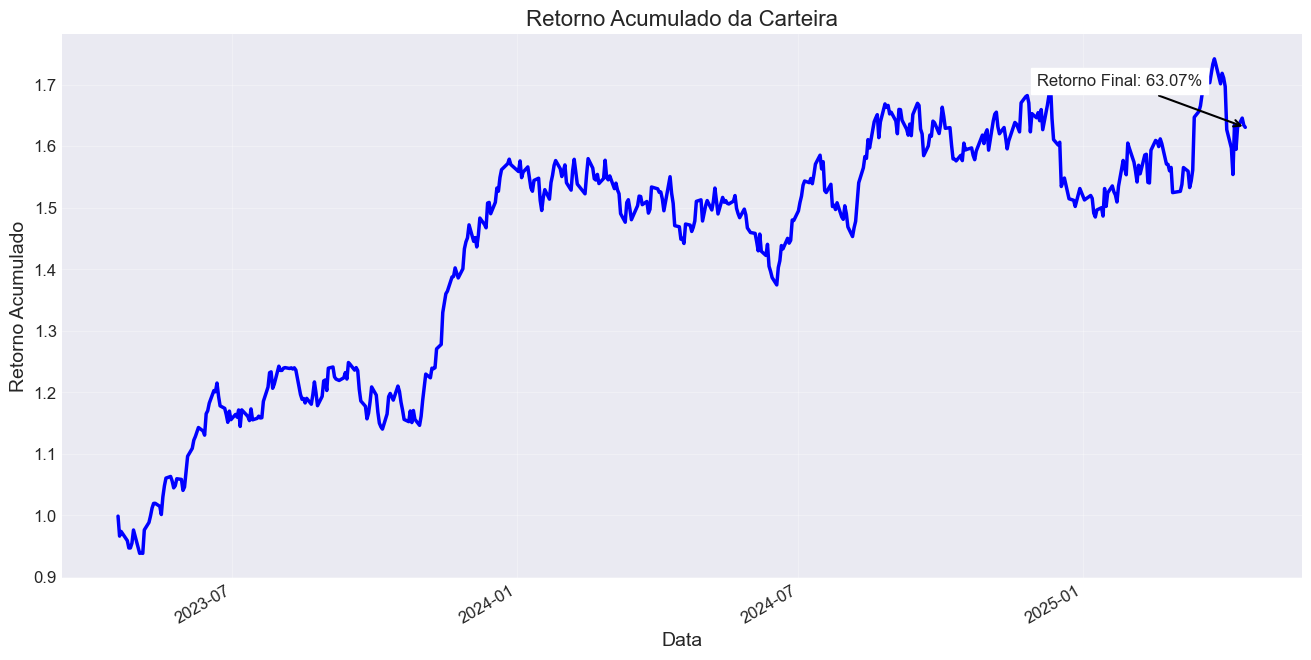

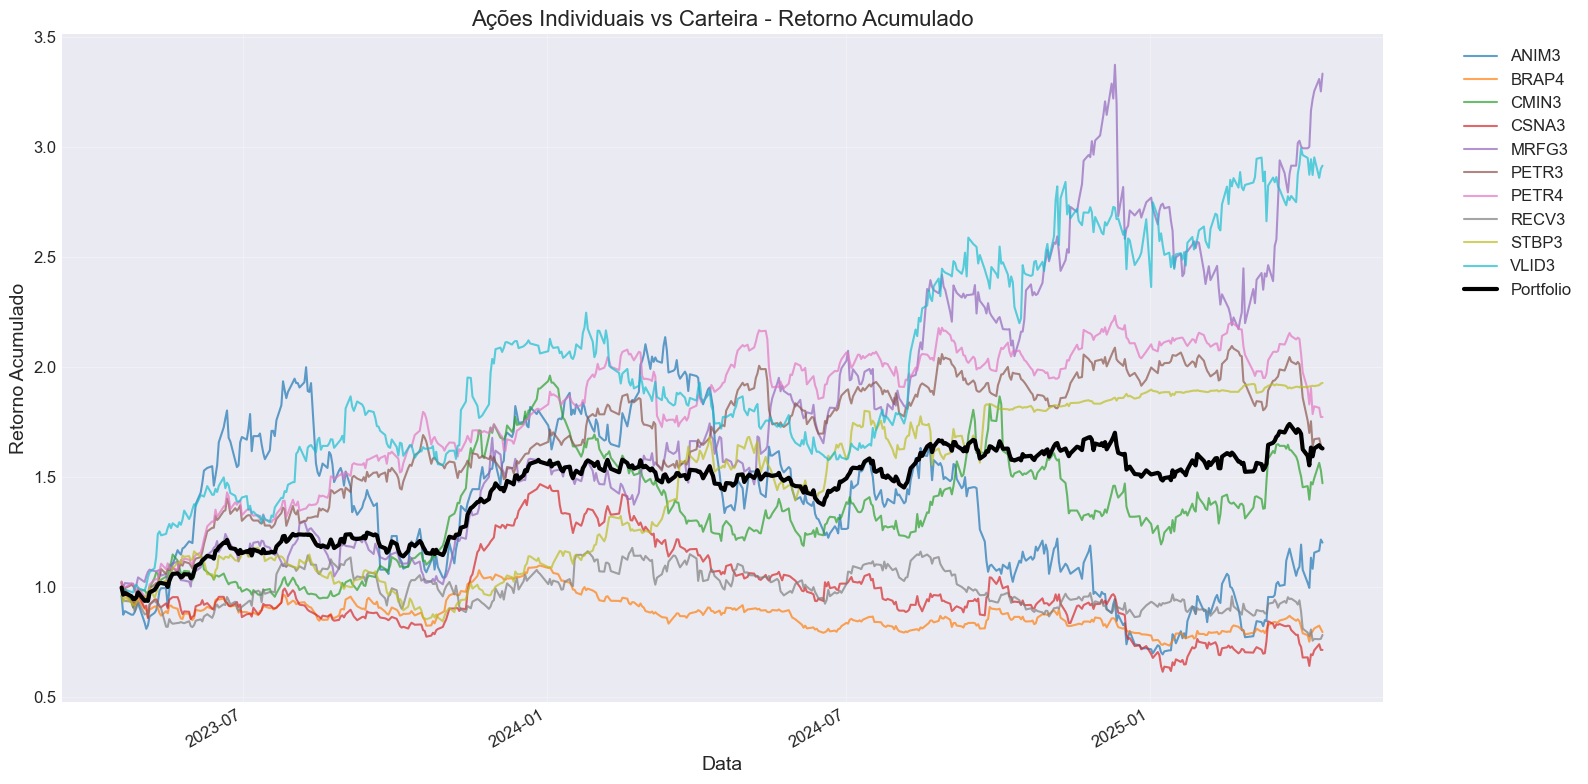

In [39]:
def plot_backtest_results(stock_returns, portfolio_returns):
    # Plot the portfolio performance
    plt.figure(figsize=(16, 8))
    plt.plot(portfolio_returns, linewidth=2.5, color='blue')
    plt.title('Retorno Acumulado da Carteira', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Retorno Acumulado', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Format x-axis and add final return annotation
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gcf().autofmt_xdate()
    
    final_return = portfolio_returns.iloc[-1] - 1
    plt.annotate(f'Retorno Final: {final_return:.2%}', 
                 xy=(portfolio_returns.index[-1], portfolio_returns.iloc[-1]),
                 xytext=(-150, 30), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', lw=1.5),
                 fontsize=12, backgroundcolor='white')
    
    plt.show()
    
    # Plot individual stocks performance if requested
    plt.figure(figsize=(16, 8))
    
    # Plot each individual stock
    for column in stock_returns.columns:
        ticker_name = column.split('.')[0] if isinstance(column, str) else str(column)
        plt.plot(stock_returns[column], alpha=0.7, linewidth=1.5, label=ticker_name)
    
    # Add portfolio for comparison
    plt.plot(portfolio_returns, linewidth=3, color='black', label='Portfolio')
    
    plt.title('Ações Individuais vs Carteira - Retorno Acumulado', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Retorno Acumulado', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

# Plot the backtest results
plot_backtest_results(stock_returns, portfolio_returns)

## Calculando Métricas de Desempenho

Vamos calcular algumas métricas importantes para avaliar o desempenho da nossa carteira:

In [40]:
def calculate_performance_metrics(returns, risk_free_rate=0.1):
    # Convert Series to DataFrame for consistent handling
    if isinstance(returns, pd.Series):
        returns_df = pd.DataFrame(returns, columns=['Portfolio'])
    else:
        returns_df = returns.copy()
    
    # Daily returns
    daily_returns = returns_df.pct_change().dropna()
    
    # Initialize results dictionary
    metrics = {}
    
    for column in daily_returns.columns:
        series = daily_returns[column]
        
        # Calculate metrics
        total_return = returns_df[column].iloc[-1] / returns_df[column].iloc[0] - 1
        cagr = (1 + total_return) ** (252 / len(returns_df)) - 1  # Annualized return (252 trading days)
        volatility = series.std() * np.sqrt(252)  # Annualized volatility
        sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        cumulative = (1 + series).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative / running_max) - 1
        max_drawdown = drawdown.min()
        
        # Store metrics
        metrics[column] = {
            'Retorno Total': total_return,
            'CAGR': cagr,
            'Volatilidade': volatility,
            'Índice Sharpe': sharpe,
            'Drawdown Máximo': max_drawdown
        }
    
    return pd.DataFrame(metrics).T



# Function to display formatted metrics
def display_metrics(returns, title, risk_free=RISK_FREE_RATE):
    metrics = calculate_performance_metrics(returns, risk_free)
    print(f"{title}:")

    # Define formatting for metrics display
    format_dict = {
        'Retorno Total': '{:.2%}',
        'CAGR': '{:.2%}',
        'Volatilidade': '{:.2%}',
        'Índice Sharpe': '{:.2f}',
        'Drawdown Máximo': '{:.2%}'
    }
    display(metrics.sort_values(by='Retorno Total', ascending=False).style.format(format_dict))

# Calculate and display metrics for both portfolio and individual stocks
display_metrics(portfolio_returns, "Métricas de Performance da Carteira")
display_metrics(stock_returns, "\nMétricas de Performance das Ações Individuais")
            

Métricas de Performance da Carteira:


,Retorno Total,CAGR,Volatilidade,Índice Sharpe,Drawdown Máximo
Portfolio,63.26%,28.09%,22.21%,0.72,-12.99%



Métricas de Performance das Ações Individuais:


,Retorno Total,CAGR,Volatilidade,Índice Sharpe,Drawdown Máximo
MRFG3.SA,226.54%,81.78%,46.38%,1.50,-35.60%
VLID3.SA,194.33%,72.49%,42.05%,1.44,-29.85%
STBP3.SA,99.11%,41.59%,31.33%,0.94,-28.30%
PETR4.SA,72.97%,31.88%,27.55%,0.72,-20.59%
PETR3.SA,59.07%,26.42%,29.73%,0.49,-22.19%
CMIN3.SA,46.95%,21.46%,39.61%,0.24,-39.44%
ANIM3.SA,25.35%,12.08%,66.87%,0.00,-67.46%
RECV3.SA,-18.56%,-9.85%,39.09%,-0.56,-35.76%
BRAP4.SA,-21.49%,-11.50%,24.85%,-0.95,-33.06%
CSNA3.SA,-29.78%,-16.35%,40.79%,-0.70,-58.03%


## Limitações da Estratégia

Esta estratégia de backtest tem várias limitações importantes que precisam ser consideradas:

### Viés de Sobrevivência (Survivorship Bias)

Nossa análise considera apenas as ações que existem atualmente. Ações que foram deslistadas ou que faliram não estão incluídas, o que pode superestimar os retornos históricos da estratégia.

### Viés de Seleção (Look-Ahead Bias)

O principal problema desta análise é que selecionamos as ações com os maiores dividendos atuais e então verificamos seu desempenho passado. Na vida real, não teríamos conhecimento destes dividendos no passado. Uma estratégia mais realista seria:

1. Para cada data histórica, selecionar as ações com os maiores dividendos naquela data
2. Rebalancear a carteira periodicamente conforme os dividendos mudam
3. Avaliar o desempenho considerando apenas informações disponíveis em cada ponto no tempo

### Alterações nos Dividendos

Os dividendos podem mudar significativamente ao longo do tempo. Empresas podem reduzir, aumentar ou suspender o pagamento de dividendos dependendo de sua situação financeira.

## Carteiras Quantitativas

As [carteiras quantitativas do QuantBrasil](https://quantbrasil.com.br/carteiras-quantitativas) resolvem o problema do rebalanceamento automático.

# ![Carteiras Quantitativas](https://rafaelquintanilha.com/content/images/2025/04/CleanShot-2025-04-15-at-14.22.03@2x.png)

# ![Carteiras Quantitativas em Ação](https://rafaelquintanilha.com/content/images/2025/04/CleanShot-2025-04-15-at-14.25.46.gif)
# 
